# House Price Prediction Notebook

This notebook predicts house prices using multiple regression models. We
preprocess the data, handle missing values, scale features, encode categorical
variables, and train several models including Ridge, LightGBM, and CatBoost.
Finally, we use a weighted ensemble to produce predictions.

# 📦 Step 1 — Import Libraries

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# LightGBM & CatBoost
import lightgbm as lgb
from catboost import CatBoostRegressor


# 📁 Step 2 — Load Data

In [2]:
train = pd.read_csv("/kaggle/input/mlp-term-3-2025-kaggle-assignment-1/train.csv")
test = pd.read_csv("/kaggle/input/mlp-term-3-2025-kaggle-assignment-1/test.csv")
sample = pd.read_csv("/kaggle/input/mlp-term-3-2025-kaggle-assignment-1/sample_submission.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()


Train shape: (10000, 9)
Test shape: (3320, 8)


,id,area_type,availability,location,size,total_sqft,bath,balcony,price
0,0,type_I,Ready To Move,Banashankari 2 nd Stage,3 BHK,1030.0,2.0,2.0,77.25
1,1,type_I,Ready To Move,Balagere,2 BHK,1210.0,2.0,1.0,83.00
2,2,type_I,17-Oct,Banashankari Stage V,3 BHK,1540.0,3.0,2.0,48.51
3,3,type_I,Ready To Move,Thigalarapalya,3 BHK,1830.0,4.0,2.0,135.00
4,4,type_III,Ready To Move,arudi,3 Bedroom,NaN,2.0,0.0,80.00


## Dataset Overview

We first check the structure of the dataset and the data types of each column. This
helps us identify numerical and categorical features and understand the general
distribution of values.

In [3]:
# Check data types
train.info()
# Descriptive statistics of numerical columns
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            10000 non-null  int64  
 1   area_type     10000 non-null  object 
 2   availability  10000 non-null  object 
 3   location      9999 non-null   object 
 4   size          9987 non-null   object 
 5   total_sqft    9967 non-null   float64
 6   bath          9936 non-null   float64
 7   balcony       9525 non-null   float64
 8   price         10000 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 703.3+ KB


,id,total_sqft,bath,balcony,price
count,10000.00000,9967.000000,9936.000000,9525.000000,10000.000000
mean,4999.50000,1570.095822,2.692029,1.585302,113.275879
std,2886.89568,1302.566836,1.274172,0.814347,151.802643
min,0.00000,1.000000,1.000000,0.000000,8.000000
25%,2499.75000,1100.000000,2.000000,1.000000,50.000000
50%,4999.50000,1279.000000,2.000000,2.000000,72.000000
75%,7499.25000,1682.500000,3.000000,2.000000,120.000000
max,9999.00000,52272.000000,18.000000,3.000000,3600.000000


# 🧹 Step 3 — Drop ID if exists

## Handling Missing Values
We identify missing values in the dataset. Missing numerical values are imputed
with the mean to ensure models receive complete data.

In [4]:
if 'id' in train.columns:
    train.drop('id', axis=1, inplace=True)
if 'id' in test.columns:
    test.drop('id', axis=1, inplace=True)

# 🔧 Step 4 — Feature Engineering

In [5]:
if 'sqft_living' in train.columns and 'sqft_lot' in train.columns:
    train['total_area'] = train['sqft_living'] + train['sqft_lot']
    test['total_area'] = test['sqft_living'] + test['sqft_lot']

if 'year_built' in train.columns:
    train['age'] = 2025 - train['year_built']
    test['age'] = 2025 - test['year_built']


# 🎯 Step 5 — Separate Features and Target

In [6]:

y = train['price']
X = train.drop('price', axis=1)

# Log-transform target for better regression
y_log = np.log1p(y)


# ⚡ Step 6 — One-hot Encoding

## Handling Categorical Variables

Categorical features are converted into numeric features using one-hot encoding
so that models can interpret them.

In [7]:
categorical = X.select_dtypes(include='object').columns
X = pd.get_dummies(X, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

# Align test columns with train
test = test.reindex(columns=X.columns, fill_value=0)


# ⚖ Step 7 — Handle Skewed Features

## Handling Skewed Features
Skewed numerical features can affect model performance. We apply log-transform
to reduce skewness and mitigate the impact of outliers.

In [8]:
from scipy.stats import skew

numeric_feats = X.select_dtypes(include=[np.number])
skewed_feats = numeric_feats.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_cols = skewed_feats[abs(skewed_feats) > 0.75].index

for col in skewed_cols:
    X[col] = np.log1p(X[col])
    test[col] = np.log1p(test[col])


# ⚖ Step 8 — Scale & Handle Missing Values

## Scaling Numerical Features

We standardize numerical features using StandardScaler. This is important for
models sensitive to feature magnitude such as Ridge regression.

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test)

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_scaled)
test_imputed = imputer.transform(test_scaled)

print("✅ Preprocessing done!")


✅ Preprocessing done!


# Lets Visualize ( Before Continuing )

We visualize the dataset to understand distributions and relationships with the
target variable.

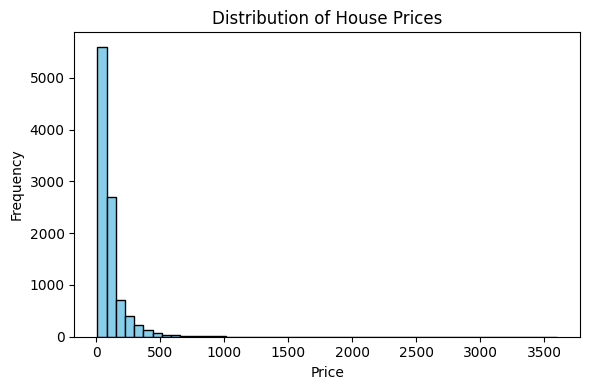

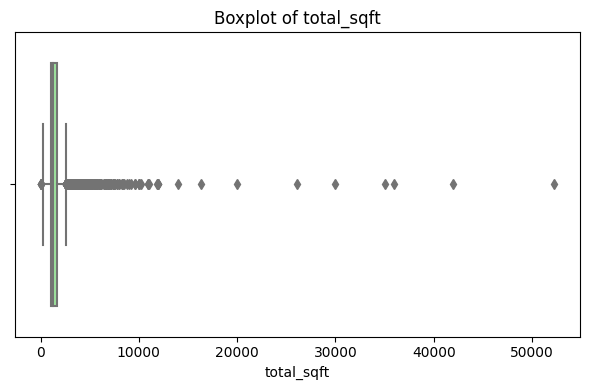

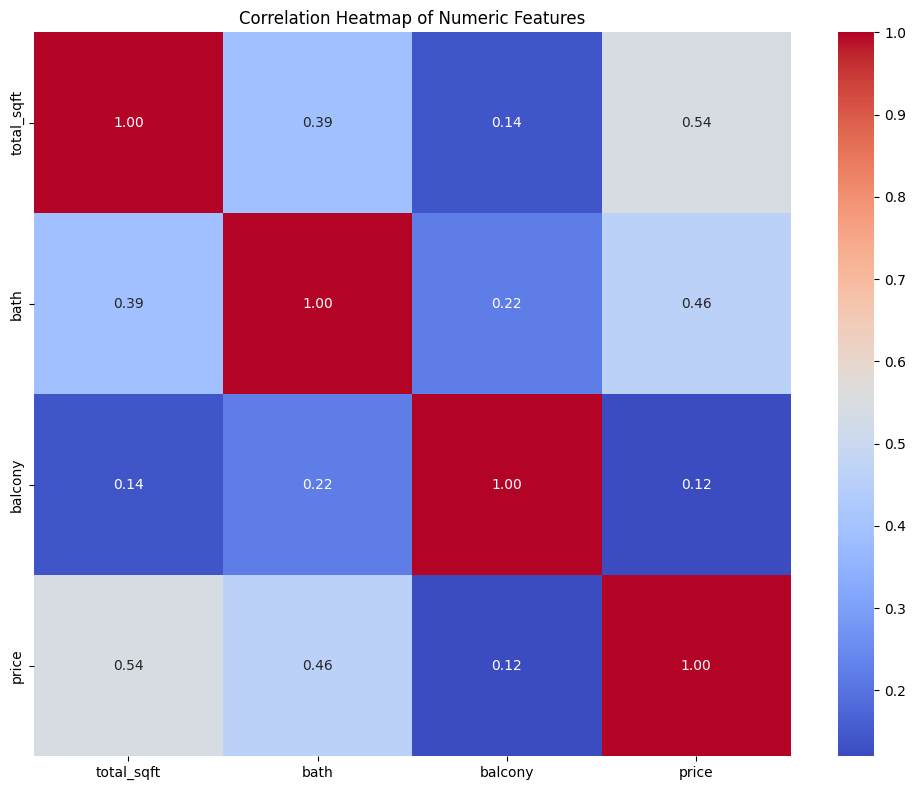

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Histogram of target variable (price)
plt.figure(figsize=(6, 4))
plt.hist(train['price'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 2️⃣ Boxplot of the largest numeric feature (as a proxy for living area)
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
if 'price' in numeric_cols:
    numeric_cols.remove('price')  # remove target variable

# Find the numeric feature with the largest total sum
largest_feature = train[numeric_cols].sum().sort_values(ascending=False).index[0]

plt.figure(figsize=(6, 4))
sns.boxplot(x=train[largest_feature], color='lightgreen')
plt.title(f'Boxplot of {largest_feature}')
plt.xlabel(largest_feature)
plt.tight_layout()
plt.show()

# 3️⃣ Correlation heatmap (numeric features only)
numeric_train = train.select_dtypes(include=[np.number])
corr = numeric_train.corr().round(2)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()


# ⚡ Step 9 — Train/Validation Split

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X_imputed, y_log, test_size=0.2, random_state=42)

# 🤖 Step 10 — Ridge Regression

## Model Training

We train multiple models including Ridge, LightGBM, and CatBoost. Training
multiple models allows comparison and ensemble predictions.

In [12]:
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train, y_train)
ridge_preds_valid = ridge.predict(X_valid)
ridge_rmse = np.sqrt(mean_squared_error(y_valid, ridge_preds_valid))
print(f"Ridge RMSE (log-target): {ridge_rmse:.4f}")


Ridge RMSE (log-target): 0.3307


# 🤖 Step 11 — LightGBM

In [13]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42
}

lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
)

lgb_preds_valid = lgb_model.predict(X_valid)
print(f"LightGBM RMSE (log-target): {np.sqrt(mean_squared_error(y_valid, lgb_preds_valid)):.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 130
[LightGBM] [Info] Start training from score 4.416407
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.310793	valid_1's rmse: 0.340547
[200]	training's rmse: 0.295683	valid_1's rmse: 0.337344
[300]	training's rmse: 0.286017	valid_1's rmse: 0.336516
Early stopping, best iteration is:
[278]	training's rmse: 0.287766	valid_1's rmse: 0.336347
LightGBM RMSE (log-target): 0.3363


# 🤖 Step 12 — CatBoost

In [14]:
cat_model = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6, eval_metric='RMSE',
                              random_seed=42, verbose=100)
cat_model.fit(X_train, y_train, eval_set=(X_valid, y_valid))
cat_preds_valid = cat_model.predict(X_valid)
print(f"CatBoost RMSE (log-target): {np.sqrt(mean_squared_error(y_valid, cat_preds_valid)):.4f}")


0:	learn: 0.6898042	test: 0.6941106	best: 0.6941106 (0)	total: 61.7ms	remaining: 1m 1s
100:	learn: 0.3441920	test: 0.3558133	best: 0.3558133 (100)	total: 760ms	remaining: 6.77s
200:	learn: 0.3274415	test: 0.3455167	best: 0.3455159 (198)	total: 1.46s	remaining: 5.8s
300:	learn: 0.3156914	test: 0.3382367	best: 0.3382367 (300)	total: 2.15s	remaining: 5s
400:	learn: 0.3062795	test: 0.3325151	best: 0.3325151 (400)	total: 2.9s	remaining: 4.34s
500:	learn: 0.2993433	test: 0.3287039	best: 0.3287039 (500)	total: 3.62s	remaining: 3.6s
600:	learn: 0.2930277	test: 0.3260061	best: 0.3260061 (600)	total: 4.29s	remaining: 2.85s
700:	learn: 0.2869483	test: 0.3231522	best: 0.3231522 (700)	total: 4.98s	remaining: 2.12s
800:	learn: 0.2826936	test: 0.3213462	best: 0.3213462 (799)	total: 5.64s	remaining: 1.4s
900:	learn: 0.2780281	test: 0.3192636	best: 0.3192636 (900)	total: 6.3s	remaining: 692ms
999:	learn: 0.2736783	test: 0.3173679	best: 0.3173679 (999)	total: 7.03s	remaining: 0us

bestTest = 0.317367904

# 🧠 Step 13 — Weighted Ensemble

## Ensemble Predictions
We combine predictions from Ridge, LightGBM, and CatBoost using weighted
average for improved performance.

In [15]:

ensemble_valid = 0.2*ridge_preds_valid + 0.4*lgb_preds_valid + 0.4*cat_preds_valid
ensemble_rmse = np.sqrt(mean_squared_error(y_valid, ensemble_valid))
print(f"Ensemble RMSE (log-target): {ensemble_rmse:.4f}")


Ensemble RMSE (log-target): 0.3105


# 📤 Step 14 — Train Full Data & Predict Test

In [16]:
ridge.fit(X_imputed, y_log)
lgb_model = lgb.train(lgb_params, lgb.Dataset(X_imputed, label=y_log), num_boost_round=lgb_model.best_iteration)
cat_model.fit(X_imputed, y_log)

ridge_preds_test = ridge.predict(test_imputed)
lgb_preds_test = lgb_model.predict(test_imputed)
cat_preds_test = cat_model.predict(test_imputed)

# Weighted ensemble
ensemble_preds_test = 0.2*ridge_preds_test + 0.4*lgb_preds_test + 0.4*cat_preds_test

# Inverse log-transform
final_preds = np.expm1(ensemble_preds_test)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 155
[LightGBM] [Info] Start training from score 4.414894
0:	learn: 0.6909059	total: 9.02ms	remaining: 9.01s
100:	learn: 0.3448800	total: 715ms	remaining: 6.36s
200:	learn: 0.3292367	total: 1.42s	remaining: 5.64s
300:	learn: 0.3185015	total: 2.14s	remaining: 4.96s
400:	learn: 0.3101388	total: 2.84s	remaining: 4.24s
500:	learn: 0.3024449	total: 3.54s	remaining: 3.53s
600:	learn: 0.2965605	total: 4.24s	remaining: 2.82s
700:	learn: 0.2911528	total: 4.92s	remaining: 2.1s
800:	learn: 0.2861496	total: 5.62s	remaining: 1.4s
900:	learn: 0.2822814	total: 6.32s	remaining: 695ms
999:	learn: 0.2785621	total: 7s	remaining: 0us


# 📤 Step 15 — Submission

In [17]:
submission = pd.DataFrame({
    'id': sample['id'] if 'id' in sample.columns else np.arange(len(final_preds)),
    'price': final_preds
})
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv saved successfully!")
submission.head()


✅ submission.csv saved successfully!


,id,price
0,0,65.163472
1,1,103.849197
2,2,58.538174
3,3,151.197364
4,4,185.848993
